In [17]:
import csv
import cv2
import numpy as np
import sklearn
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers.core import Dense, Flatten, Activation, Dropout, Lambda
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
# Visualizations will be shown in the notebook.
%matplotlib inline

In [35]:
samples = []
with open('data/data/driving_log.csv') as csvfile:
    line = csvfile.readlines()
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

In [50]:
#car_images = []
#steering_angles = []
i=0

def process_image(image):
    
    shape = image.shape
    # note: numpy arrays are (row, col)!
    image = image[math.floor(shape[0]/4):shape[0]-25, 0:shape[1]]
    
    i = 1+1
    if i==100:
        print(image.shape)
        plt.imshow(image)
    return image

(100, 320, 3)


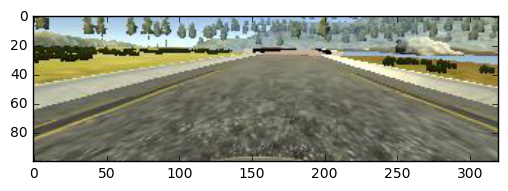

In [51]:
#Sample processing on first image in csv file
import math
import matplotlib.pyplot as plt
path = 'data/data/' # fill in the path to your training IMG directory

#img_center1 = process_image(np.asarray(Image.open(path+first_line[0:38])))
img_center1 = process_image(np.asarray(Image.open(path+line[55][0:38])))  #line[x][0:38], x is row number, [0:38] is characters of first coulmn of that row..
print(img_center1.shape)
plt.imshow(img_center1)

In [20]:
def generator(samples, batch_size=256):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            car_images = []
            steering_angles = []
            for row in batch_samples:
                steering_center = float(row[3])

                # create adjusted steering measurements for the side camera images
                correction = 0.1     # this is a parameter to tune
                steering_left = steering_center + correction
                steering_right = steering_center - correction
    
                # read in images from center, left and right cameras
                path = 'data/data/' # fill in the path to your training IMG directory
                img_center = process_image(np.asarray(Image.open(path+row[0])))
                img_center_flipped = np.fliplr(img_center)
                img_left = process_image(np.asarray(Image.open(path+row[1])))
                img_left_flipped = np.fliplr(img_left)
                img_right = process_image(np.asarray(Image.open(path + row[2])))
                img_right_flipped = np.fliplr(img_right)
    
                # add images and angles to data set
                car_images.append(img_center)
                car_images.append(img_center_flipped)
                car_images.append(img_left)
                car_images.append(img_left_flipped)
                car_images.append(img_right)
                car_images.append(img_right_flipped)
                steering_angles.append(steering_center)
                steering_angles.append(-steering_center)
                steering_angles.append(steering_left)
                steering_angles.append(-steering_left)
                steering_angles.append(steering_right)
                steering_angles.append(-steering_right)

            # trim image to only see section with road
            X_train = np.array(car_images)
            y_train = np.array(steering_angles)
            #print(X_train.shape, y_train.shape)
            yield sklearn.utils.shuffle(X_train, y_train)

In [21]:
# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=64)
validation_generator = generator(validation_samples, batch_size=64)
train_generator

<generator object generator at 0x7f0c21706db0>

In [9]:
model = Sequential()
model.add(Lambda(lambda x: x/255.0 - 0.5, input_shape=(160,320,3)))
model.add(Convolution2D(6,5,5, activation="relu"))
model.add(MaxPooling2D())		#or can be MaxPooling2D((2, 2))
model.add(Convolution2D(6,5,5, activation="relu"))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(128))
model.add(Dropout(0.5))
model.add(Dense(75))
model.add(Dense(1))

In [12]:
model.compile(loss='mse', optimizer='adam')
#model.fit(X_train, y_train,validation_split=0.2, shuffle=True, nb_epoch=7)
model.fit_generator(train_generator, samples_per_epoch= \
            len(train_samples)*6, validation_data=validation_generator, \
            nb_val_samples=len(validation_samples)*6, nb_epoch=3)         #https://keras.io/models/sequential/#fit_generator

model.save('model_test.h5')

Epoch 1/3
(384, 160, 320, 3) (384,)
(384, 160, 320, 3) (384,)
(384, 160, 320, 3) (384,)
  384/38568 [..............................] - ETA: 172s - loss: 0.0270(384, 160, 320, 3) (384,)
(384, 160, 320, 3) (384,)
  768/38568 [..............................] - ETA: 141s - loss: 0.0239(384, 160, 320, 3) (384,)
(384, 160, 320, 3) (384,)
 1152/38568 [..............................] - ETA: 130s - loss: 0.0246(384, 160, 320, 3) (384,)
(384, 160, 320, 3) (384,)
 1536/38568 [>.............................] - ETA: 124s - loss: 0.0238(384, 160, 320, 3) (384,)
(384, 160, 320, 3) (384,)
 1920/38568 [>.............................] - ETA: 119s - loss: 0.0239(384, 160, 320, 3) (384,)
(384, 160, 320, 3) (384,)
(384, 160, 320, 3) (384,)
 2304/38568 [>.............................] - ETA: 116s - loss: 0.0217(384, 160, 320, 3) (384,)
(384, 160, 320, 3) (384,)
 2688/38568 [=>............................] - ETA: 114s - loss: 0.0209(384, 160, 320, 3) (384,)
(384, 160, 320, 3) (384,)
38184/38568 [============